In [4]:
import os

os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
# Different per process:
os.environ["TPU_VISIBLE_DEVICES"] = "1"

# Hard EM - VAE: Fashion MNIST

In this notebook, we test the effectiveness and speed of hard-EM applied to a factor analysis and homoskedastic encoder.

We test this notebook considering an adam optimiser for both the VAE and the E and M steps of DLM hard EM.

In [5]:
import jax
import hlax
import optax
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from functools import partial
from flax.training.train_state import TrainState
from torchvision.datasets import FashionMNIST

In [6]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
jnp.set_printoptions(suppress=True, precision=5, linewidth=120)

## Create train dataset

In [7]:
root = "/tmp/fashion-mnist"
mnist_train = FashionMNIST(root, download=True, train=True)
mnist_test = FashionMNIST(root, download=True, train=False)

In [8]:
n_train = 1000
n_test = 500

y_train = jnp.array(mnist_train.targets)

X_train = jnp.array(mnist_train.data)[:n_train + n_test]
X_train = X_train.reshape(-1, 28 ** 2)

y_train = y_train[:n_train + n_test]
dim_output = len(jnp.unique(y_train))

num_train, dim_obs = X_train.shape
# "Gaussanised" MNIST
# X_train = X_train[..., None]
xmax = X_train.max()

X_train = X_train / xmax

xmean = X_train.mean()
xstd = X_train.std()
X_train = (X_train - xmean) / xstd

y_ohe_train = jax.nn.one_hot(y_train, dim_output)
num_samples = len(X_train)

X_test = X_train[-n_test:]
y_test = y_train[-n_test:]
y_ohe_test = y_ohe_train[-n_test:]

X_train = X_train[:-n_test]
y_train = y_train[:-n_test]
y_ohe_train = y_ohe_train[:-n_test]


X_train.shape

(1000, 784)

## Setup

In [9]:
key = jax.random.PRNGKey(314)
key_vae, key_hard_em, key_test = jax.random.split(key, 3)

In [10]:
dim_latent = 50
n_epochs = 1000

## VAE 

In [11]:
class Encoder(nn.Module):
    """
    For the inference model p(z|x)
    """
    latent_dim: int
    n_hidden: int = 5
    
    @nn.compact
    def __call__(self, x):
        z = nn.Dense(self.n_hidden)(x)
        z = nn.relu(z)
        z = nn.Dense(self.n_hidden)(z)
        z = nn.relu(z)
        mean_z = nn.Dense(self.latent_dim)(z)
        logvar_z = nn.Dense(self.latent_dim)(z)
        return mean_z, logvar_z

In [12]:
key_params_init, key_eps_init, key_train = jax.random.split(key_vae, 3)

In [13]:
batch_size = 200
n_hidden = 100
batch_init = jnp.ones((batch_size, dim_obs))

Decoder = hlax.models.HomkDecoder
model = hlax.models.VAE_IW(dim_latent, dim_obs, Encoder, Decoder)

params_init = model.init(key_params_init, batch_init, key_eps_init, num_samples=3)

In [14]:
tx = optax.adam(1e-3)
state = TrainState.create(
    apply_fn=partial(model.apply, num_samples=50),
    params=params_init,
    tx=tx
)

In [15]:
keys_train = jax.random.split(key_train, n_epochs)
hist_vae_loss = []

loss_old = -jnp.inf
for e, keyt in (pbar := tqdm(enumerate(keys_train), total=len(keys_train))):
    loss, state = hlax.vae.train_epoch(keyt, state, X_train, batch_size)
    
    hist_vae_loss.append(loss)
        
    pbar.set_description(f"{loss=:.3e}")
params_vae = state.params

  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
hist_vae_mll = -jnp.array(hist_vae_loss)

## Hard EM LVM

In [19]:
%%time

decoder = hlax.models.HomkDecoder(dim_obs, dim_latent)
lossfn = hlax.hard_decoder.loss_hard_nmll

tx_params = optax.adam(1e-3)
tx_latent = optax.adam(1e-3)

key_init, key_step = jax.random.split(key_hard_em)

states = hlax.hard_decoder.initialise_state(key, decoder, tx_params,
                                            tx_latent, X_train, dim_latent)
opt_states, target_states = states
params_decoder, z_decoder = target_states

 
n_its_params, n_its_latent = 20, 30
nll_hist = []
for e in tqdm(range(n_epochs)):
    res = hlax.hard_decoder.train_epoch_adam(key_step, params_decoder, z_decoder,
                                        opt_states, X_train, batch_size, decoder, tx_params, tx_latent,
                                        n_its_params, n_its_latent, lossfn)
    nll, params_decoder, z_decoder, opt_states = res
    nll_hist.append(nll)
    print(f"{nll:0.4e}", end="\r")

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 12.3 s, sys: 3.16 s, total: 15.5 s
Wall time: 11 s


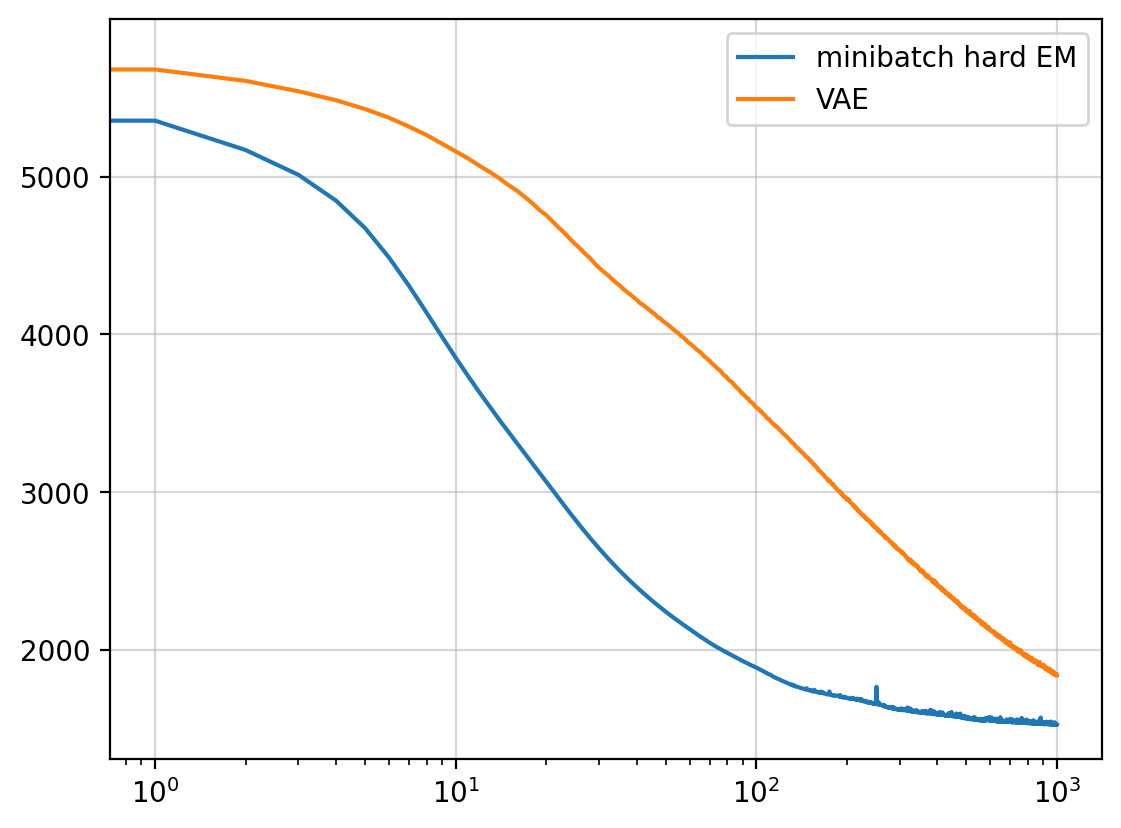

In [20]:
plt.plot(nll_hist, label="minibatch hard EM")
plt.plot(hist_vae_loss, label="VAE")
plt.legend()
plt.xscale("log")
plt.grid(alpha=0.5)

## Finding a distribution for $q_n$

In [23]:
import distrax
from typing import Callable
from flax.core import freeze, unfreeze

In [32]:
n_samples, _ = X_train.shape
keys_test, key_eval = jax.random.split(key_test)
keys_test = jax.random.split(keys_test, n_samples)

In [184]:
class GaussEncoder(nn.Module):
    dim_latent: int
    normal_init: Callable = nn.initializers.normal()
    
    
    def setup(self):
        self.mu = self.param("mu", self.normal_init, (self.dim_latent,))
        self.logvar_diag = self.param("logvar_diag", self.normal_init, (self.dim_latent,))
        
    def sample_proposal(self, key, num_samples):
        std = jnp.exp(self.logvar_diag / 2)
        eps = jax.random.normal(key, (num_samples, dim_latent))
        z = self.mu[None, ...] + jnp.einsum("d,...d->...d", std, eps)
        return z
    
    def __call__(self, key, num_samples=1):
        std = jnp.exp(self.logvar_diag / 2)
        z_samples = self.sample_proposal(key, num_samples=num_samples)
        
        return z_samples, (self.mu, std)

In [332]:
q_approx = GaussEncoder(dim_latent)

n_samples, dim_latent = z_decoder.shape
params_latent = jax.vmap(q_approx.init)(keys_test, keys_test)

# Set initial mean parameters to estimated latent parameters
params_latent = unfreeze(params_latent)
params_latent["params"].update(mu=z_decoder, logvar_diag=-5 * jnp.ones_like(z_decoder))
# params_latent["params"].update(mu=z_decoder)
params_latent = freeze(params_latent)
jax.tree_map(jnp.shape, params_latent)

FrozenDict({
    params: {
        logvar_diag: (1000, 50),
        mu: (1000, 50),
    },
})

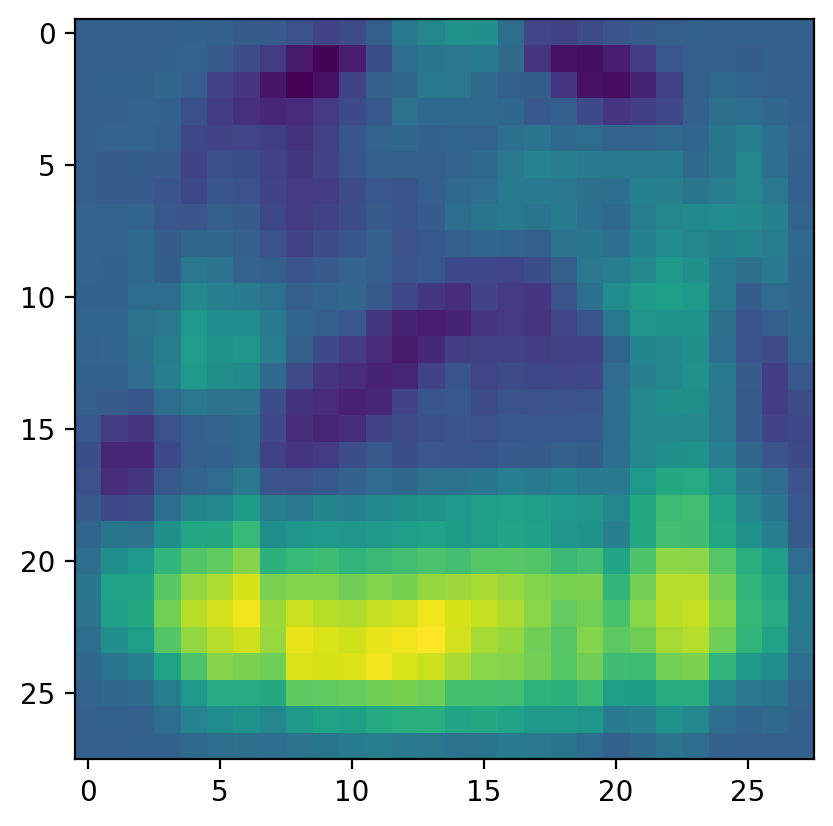

In [333]:
z_samples, (mu_z, std_z) = q_approx.apply(jax.tree_map(lambda x: x[0], params_latent), key, num_samples=1)

mu_x, logvarx = decoder.apply(params_decoder, z_samples)
plt.imshow(mu_x.mean(axis=0).reshape(28, 28))

In [306]:
mu_x, logvar_x = decoder.apply(params_decoder, z_samples)
std_x = jnp.exp(logvar_x / 2)
log_px_cond = distrax.MultivariateNormalDiag(mu_x, std_x).log_prob(X_train[0])

In [336]:
def iwmll_encoder(key, params, z_prior, observation, num_is_samples=10):
    latent_samples, (mu_z, std_z) = q_approx.apply(params, key, num_samples=num_is_samples)
    
    _, dim_latent = latent_samples.shape
    # log p(x|z)
    mu_x, logvar_x = decoder.apply(params_decoder, latent_samples)
    std_x = jnp.exp(logvar_x / 2)
    log_px_cond = distrax.MultivariateNormalDiag(mu_x, std_x).log_prob(observation)
    
    # log p(z)
    # mu_z_init, std_z_init = z_prior, jnp.ones(dim_latent)
    mu_z_init, std_z_init = jnp.zeros(dim_latent), jnp.ones(dim_latent)
    log_pz = distrax.MultivariateNormalDiag(mu_z_init, std_z_init).log_prob(latent_samples)
    
    # log q(z)
    log_qz = distrax.MultivariateNormalDiag(mu_z, std_z).log_prob(latent_samples)
    
    # Importance-weighted marginal log-likelihood
    log_prob = log_pz + log_px_cond - log_qz
    niwmll = -jax.nn.logsumexp(log_prob, axis=-1, b=1/num_is_samples)
    
    return niwmll

In [337]:
keys_eval = jax.random.split(key_eval, n_samples)

In [358]:
iwmll_vmap = jax.value_and_grad(iwmll_encoder, argnums=1)
iwmll_vmap = jax.vmap(iwmll_vmap)

In [405]:
alpha = 1e-6

q_approx = GaussEncoder(dim_latent)

n_samples, dim_latent = z_decoder.shape
params_latent = jax.vmap(q_approx.init)(keys_test, keys_test)

# Set initial mean parameters to estimated latent parameters
params_latent = unfreeze(params_latent)
# params_latent["params"].update(mu=z_decoder)
params_latent["params"].update(mu=z_decoder, logvar_diag=-5 * jnp.ones_like(z_decoder))
params_latent = freeze(params_latent)
jax.tree_map(jnp.shape, params_latent)

FrozenDict({
    params: {
        logvar_diag: (1000, 50),
        mu: (1000, 50),
    },
})

In [409]:
tx_test = optax.adam(1e-2)
latent_states = jax.vmap(tx_test.init)(params_latent)

In [410]:
hist_avg_mll = []
for i in tqdm(range(300)):
    _, key_eval = jax.random.split(key_eval)
    keys_eval = jax.random.split(key_eval, n_samples)
    mll_vals, grads = iwmll_vmap(keys_eval, params_latent, z_decoder, X_train)

    updates, latent_states = jax.vmap(tx_test.update)(grads, latent_states, params_latent)
    params_latent = jax.vmap(optax.apply_updates)(params_latent, updates)
    
    mll_mean = mll_vals.mean()
    print(f"{mll_mean:0.3e}", end="\r")
    hist_avg_mll.append(mll_mean)

  0%|          | 0/300 [00:00<?, ?it/s]

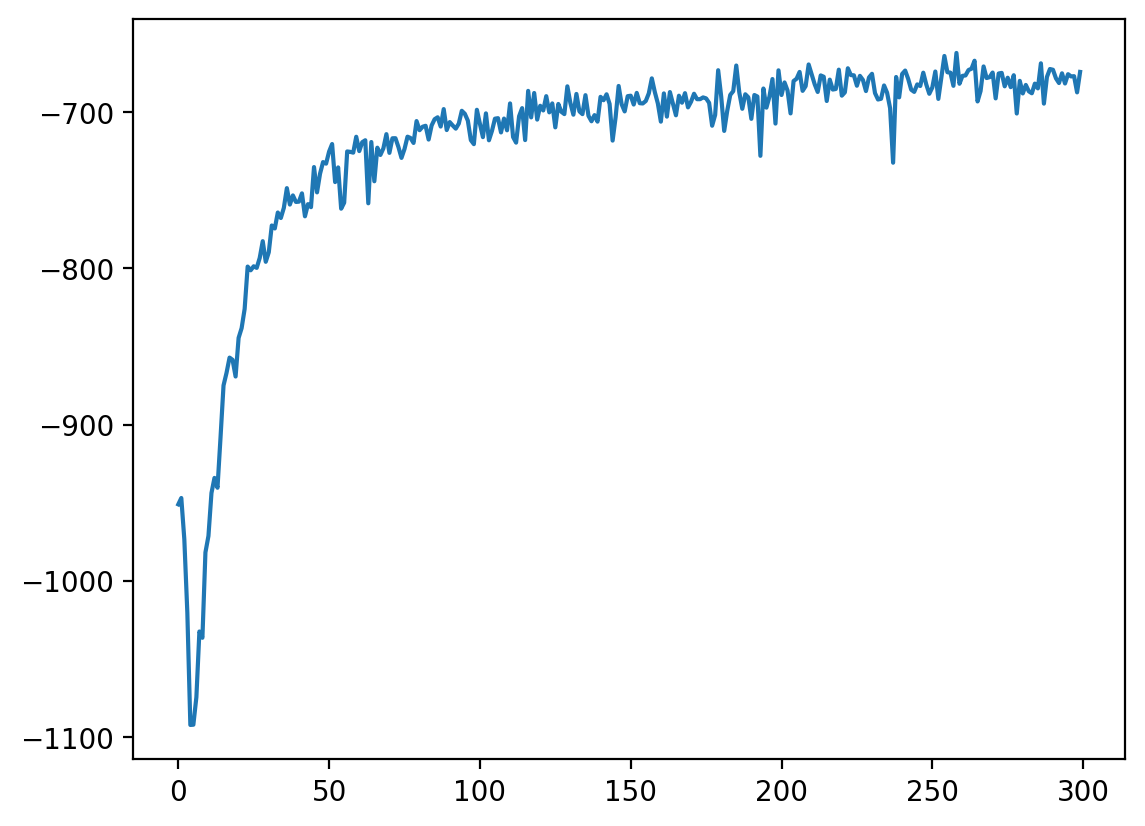

In [411]:
plt.plot(-jnp.array(hist_avg_mll))

In [412]:
z_decoder_learned = params_latent["params"]["mu"]

## Analysing posterior observations

In [413]:
def clean_axis(ax):
    """
    Source
    https://stackoverflow.com/questions/49155654
    """
    # make xaxis invisibel
    ax.xaxis.set_visible(False)
    # make spines (the box) invisible
    plt.setp(ax.spines.values(), visible=False)
    # remove ticks and labels for the left axis
    ax.tick_params(left=False, labelleft=False)
    #remove background patch (only needed for non-white background)
    ax.patch.set_visible(False)


In [414]:
n_samples = 8
# key_choice, keys_is = jax.random.split(key_samples)
key_choice, keys_is = jax.random.split(key_eval)
keys_is = jax.random.split(keys_is, n_samples)

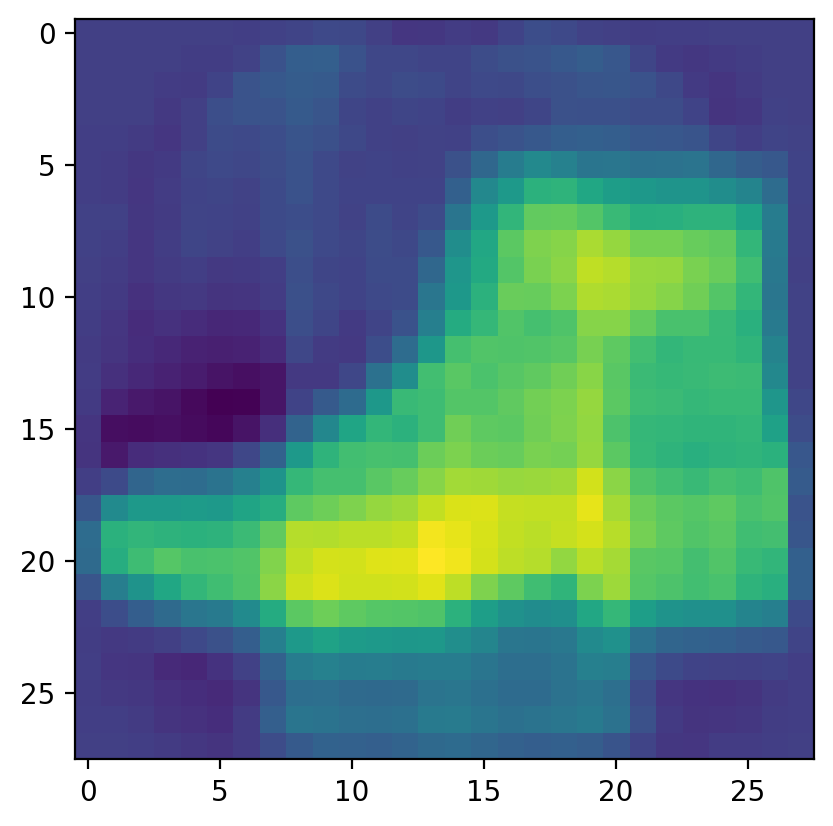

In [415]:
mean_x, var_x = decoder.apply(params_decoder, z_decoder_learned[0])
plt.imshow(mean_x.reshape(28, 28))

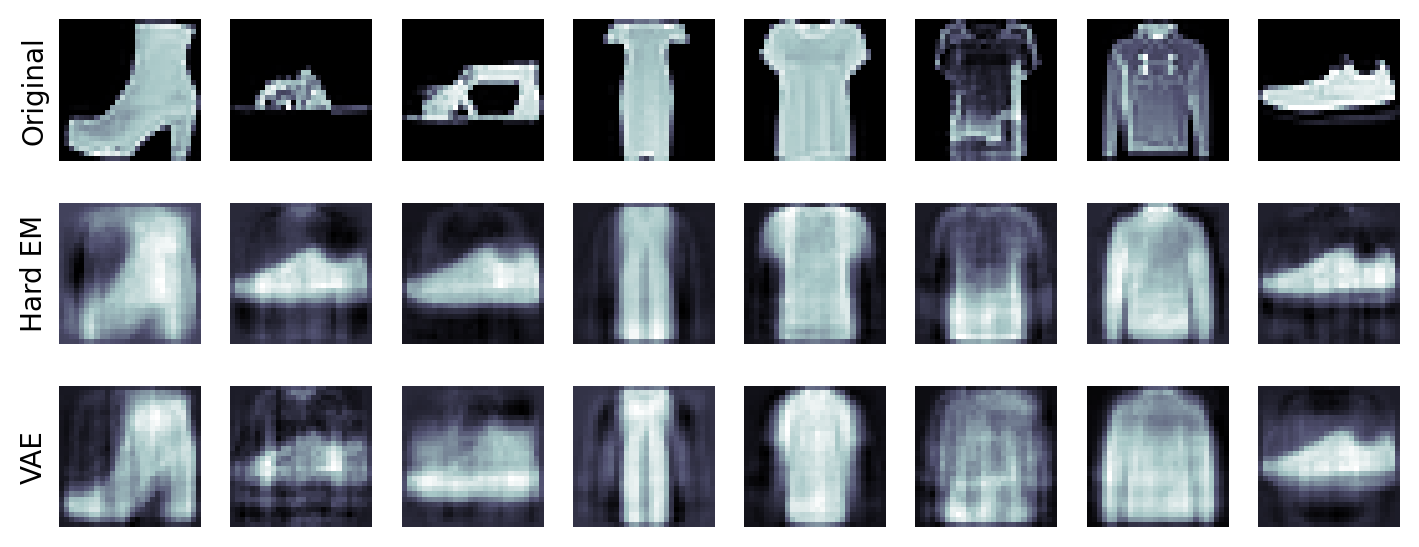

In [416]:
ixs_test = jax.random.choice(key_choice, len(X_train), (n_samples,))
fig, axs = plt.subplots(3, n_samples, figsize=(7, 3.0))

cmap = "bone"
for ax, ix, key in zip(axs.T, ixs_test, keys_is):
    obs = X_train[ix]
    mean_x, var_x = decoder.apply(params_decoder, z_decoder[ix])
    _, _, (mean_x_vae, logvar_x_vae) = model.apply(params_vae, obs, key)

    ax[0].imshow(obs.reshape(28, 28), cmap=cmap)
    ax[1].imshow(mean_x.reshape(28, 28), cmap=cmap)
    ax[2].imshow(mean_x_vae.reshape(28, 28), cmap=cmap)
    
    for axi in ax:
        clean_axis(axi)
        
plt.tight_layout()

axs[0, 0].set_ylabel("Original")
axs[1, 0].set_ylabel("Hard EM")
axs[2, 0].set_ylabel("VAE");

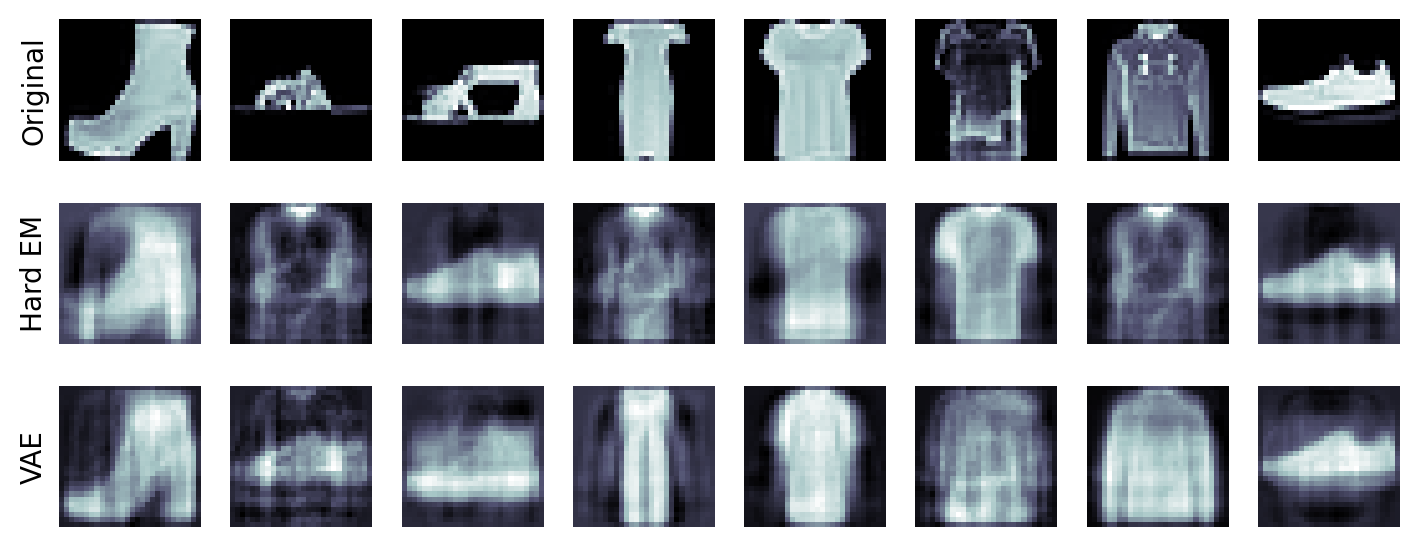

In [417]:
ixs_test = jax.random.choice(key_choice, len(X_train), (n_samples,))
fig, axs = plt.subplots(3, n_samples, figsize=(7, 3.0))

cmap = "bone"
for ax, ix, key in zip(axs.T, ixs_test, keys_is):
    obs = X_train[ix]
    mean_x, var_x = decoder.apply(params_decoder, z_decoder_learned[ix])
    _, _, (mean_x_vae, logvar_x_vae) = model.apply(params_vae, obs, key)

    ax[0].imshow(obs.reshape(28, 28), cmap=cmap)
    ax[1].imshow(mean_x.reshape(28, 28), cmap=cmap)
    ax[2].imshow(mean_x_vae.reshape(28, 28), cmap=cmap)
    
    for axi in ax:
        clean_axis(axi)
        
plt.tight_layout()

axs[0, 0].set_ylabel("Original")
axs[1, 0].set_ylabel("Hard EM")
axs[2, 0].set_ylabel("VAE");